<a href="https://colab.research.google.com/github/0xtaha/image-super-resloution-for-remote-sensing/blob/main/colab_notebooks/image_super_resolution_using_AutoEncoder_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Downloading The repo files

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!git clone https://github.com/0xtaha/image-super-resloution-for-remote-sensing

Cloning into 'image-super-resloution-for-remote-sensing'...
remote: Enumerating objects: 344, done.
remote: Counting objects: 100% (344/344), done.
remote: Compressing objects: 100% (232/232), done.
remote: Total 344 (delta 191), reused 219 (delta 94), pack-reused 0
Receiving objects: 100% (344/344), 6.04 MiB | 12.43 MiB/s, done.
Resolving deltas: 100% (191/191), done.


In [ ]:
!cp -a /content/image-super-resloution-for-remote-sensing/. /content/
!rm -rf /content/image-super-resloution-for-remote-sensing/

cp: cannot stat '/content/image-super-resloution-for-remote-sensing/.': No such file or directory


## imporintg required packages

In [ ]:
import numpy as np
import cv2
import glob
import tensorflow as tf
import os
from tqdm.notebook import tqdm, trange
from skimage.transform import resize
from matplotlib import pyplot
from tensorflow.keras import Model, Input, regularizers
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Add, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing import image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
import pandas as pd

In [ ]:
# preprocessed_data_path = '/content/gdrive/MyDrive/Datasets/draper-satellite-image-chronology/preprocessed'

## 1.Downloading The Dataset

In [ ]:
# train_images_path = '/content/gdrive/MyDrive/Datasets/draper-satellite-image-chronology/splitted/train/*.png'
# test_images_path = '/content/gdrive/MyDrive/Datasets/draper-satellite-image-chronology/splitted/test/*.png'

In [ ]:
# train_images = glob.glob(train_images_path) #returns path of images
# test_images = glob.glob(test_images_path) #returns path of images

In [ ]:
# # print('number of train images {}'.format(len(train_images)))
# print('number of test images {}'.format(len(test_images)))

In [ ]:
!wget  http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip
!unzip /content/UCMerced_LandUse.zip -d /content/;
os.remove("/content/UCMerced_LandUse.zip")

--2021-07-05 08:49:05--  http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip
Resolving weegee.vision.ucmerced.edu (weegee.vision.ucmerced.edu)... 169.236.184.65
Connecting to weegee.vision.ucmerced.edu (weegee.vision.ucmerced.edu)|169.236.184.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 332468434 (317M) [application/zip]
Saving to: ‘UCMerced_LandUse.zip’

UCMerced_LandUse.zi 100%[===================>] 317.07M   100MB/s    in 3.5s    

2021-07-05 08:49:08 (91.1 MB/s) - ‘UCMerced_LandUse.zip’ saved [332468434/332468434]

Archive:  /content/UCMerced_LandUse.zip
   creating: /content/UCMerced_LandUse/Images/
   creating: /content/UCMerced_LandUse/Images/agricultural/
  inflating: /content/UCMerced_LandUse/Images/agricultural/agricultural00.tif  
  inflating: /content/UCMerced_LandUse/Images/agricultural/agricultural01.tif  
  inflating: /content/UCMerced_LandUse/Images/agricultural/agricultural02.tif  
  inflating: /content/UCMerced_LandUse/Images

In [ ]:
dataset_path = '/content/UCMerced_LandUse'
unziped_dataset_images_path = '/content/UCMerced_LandUse/Images/**/*'

In [ ]:
Land_images = glob.glob(unziped_dataset_images_path) #returns path of images
print(len(Land_images)) #contains 13243 images

2100


## 2.Preprocessing

In [ ]:
preprocessed_data_path = '/content/preprocessed/'
number_of_images = 2100
train_images, test_images = train_test_split(Land_images[:number_of_images], random_state = 32, test_size=0.2 , train_size = 0.8)

In [ ]:
remove_images = Land_images[number_of_images+1:]
for im in remove_images:
  os.remove(im)

In [ ]:
%%bash
mkdir /content/preprocessed/
mkdir /content/preprocessed/train_x/
mkdir /content/preprocessed/train_y/
mkdir /content/preprocessed/test_x/
mkdir /content/preprocessed/test_y/

In [ ]:
from Preprocessing import Data_Preprocessing, pixalate_image
# Data_Preprocessing(images_list ,path, Preprocessed_Data_Path , resize_dim = (100 , 100) , DownSamplingMode = 'INTER_AREA')

In [ ]:
Data_Preprocessing(train_images , preprocessed_data_path ,path = 'train' , pixelation_scale = 0.4 , multithreading = True)

Done ... 


In [ ]:
Data_Preprocessing(test_images , preprocessed_data_path, path = 'test', pixelation_scale = 0.4 , multithreading = True)

Done ... 


In [ ]:
!rm -rf /content/UCMerced_LandUse

## Load preprocessed dataset

In [ ]:
x_train_path = os.path.join(preprocessed_data_path, 'train_x', '*.png')
y_train_path = os.path.join(preprocessed_data_path, 'train_y', '*.png')
x_test_path = os.path.join(preprocessed_data_path, 'test_x', '*.png')
y_test_path = os.path.join(preprocessed_data_path, 'test_y', '*.png')

In [ ]:
x_train_list = sorted(glob.glob(x_train_path))
y_train_list = sorted(glob.glob(y_train_path))
x_test_list = sorted(glob.glob(x_test_path))
y_test_list = sorted(glob.glob(y_test_path))

print(len(x_train_list), len(x_test_list))

1680 420


In [ ]:
# train_size = 6000
# x_train_list = x_train_list[train_size:]
val_index = int(len(x_train_list)*0.8)
x_val_list = x_train_list[val_index:]
y_val_list = y_train_list[val_index:]
x_train_list = x_train_list[:val_index]
y_train_list = y_train_list[:val_index]

In [ ]:
from DataGenerator import DataGenerator , ImgToArr
# (self, list_x , list_y, labels, batch_size=32, X_dim=(256,256), Y_dim=(256,256) , n_channels=3, shuffle=True)
# add X_dim , Y_dim processing to DataGenrator
train_gen = DataGenerator(list_x=x_train_list, list_y= y_train_list, labels=None, batch_size=20, n_channels=3, shuffle=True)
val_gen = DataGenerator(list_x=x_val_list, list_y= y_val_list, labels=None, batch_size=20, n_channels=3, shuffle=False)

## Combining Loss Functions

Let's try using a loss that doesn't just tell us the pixel-wise difference in resolution, but that also if there's an improvement, for example, in high frequency details.

### MSE and HFENN

We can do a weight sum of both losses like:

$MSE + weight * HFENN$

We could choose $weight = 10$ and see what happens. 

The HFENN (High Frequency Error Norm Normalized) metric gives  a  measure  of how high-frequency details differ between two images.

This means that we can guess if an image has more or less high frequency details (which are fine details that you need to zoom in to see and that are not blurry) compared to another image.

When the output value is 0 the images are identical. The greater the value, the more of a perceptual difference in both images there is.

In [ ]:
from loss import hfenn_loss , ae_loss

## 3. Metrics

In [ ]:
def ssim(y_pred, y_true):
  return tf.image.ssim(y_true, y_pred , max_val=2.0)

def psnr(y_pred, y_true):
  return tf.image.psnr(y_true, y_pred , max_val=1.0)

## 3. Model Archticture

In [ ]:
from models import Autoencoder
autoencoder = Autoencoder()

In [ ]:
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [ ]:
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=20, verbose=1, mode='min')
model_checkpoint =  ModelCheckpoint('superResolution_checkpoint3.h5', save_best_only = True)

In [ ]:
autoencoder.compile(optimizer='adam', loss=[ae_loss], metrics=[ssim,psnr,'accuracy'])

## 4. Training

In [ ]:
history = autoencoder.fit(train_gen, validation_data=val_gen,
            epochs=60 , callbacks=[early_stopper ,model_checkpoint ])

Epoch 1/60
67/67 [==============================] - 88s 683ms/step - loss: 0.0688 - ssim: 0.7161 - psnr: 18.4658 - accuracy: 0.4842 - val_loss: 0.0070 - val_ssim: 0.9001 - val_psnr: 26.8844 - val_accuracy: 0.6803
Epoch 2/60


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


67/67 [==============================] - 47s 702ms/step - loss: 0.0079 - ssim: 0.8956 - psnr: 28.1497 - accuracy: 0.8076 - val_loss: 0.0054 - val_ssim: 0.9093 - val_psnr: 29.6692 - val_accuracy: 0.8727
Epoch 3/60
67/67 [==============================] - 47s 697ms/step - loss: 0.0071 - ssim: 0.9011 - psnr: 29.0422 - accuracy: 0.8725 - val_loss: 0.0050 - val_ssim: 0.9122 - val_psnr: 30.0507 - val_accuracy: 0.8970
Epoch 4/60
67/67 [==============================] - 47s 699ms/step - loss: 0.0067 - ssim: 0.9036 - psnr: 29.2658 - accuracy: 0.8786 - val_loss: 0.0047 - val_ssim: 0.9141 - val_psnr: 30.2017 - val_accuracy: 0.8916
Epoch 5/60
67/67 [==============================] - 47s 702ms/step - loss: 0.0065 - ssim: 0.9050 - psnr: 29.2300 - accuracy: 0.8813 - val_loss: 0.0046 - val_ssim: 0.9153 - val_psnr: 30.3256 - val_accuracy: 0.9020
Epoch 6/60
67/67 [==============================] - 47s 700ms/step - loss: 0.0063 - ssim: 0.9063 - psnr: 29.5602 - accuracy: 0.8886 - val_loss: 0.0046 - val_ss

In [ ]:
autoencoder.load_weights('/content/superResolution_checkpoint3.h5')

## 5. Results

In [ ]:
from PIL import Image
# Test
x_test_images = []
y_test_images = []

bar = tqdm(total= len(x_test_list), position=0)
for x_image in x_test_list :
  x_test_images.append((np.array(Image.open(x_image) , dtype= np.float32 )[:,:,:3])/255)
  bar.update(1)
bar_2 = tqdm(total= len(x_test_list), position=0)
for y_image in y_test_list:
  y_test_images.append((np.array(Image.open(y_image), dtype= np.float32 )[:,:,:3])/255)
  bar_2.update(1)

x_test_images = np.array(x_test_images)
y_test_images = np.array(y_test_images)

In [ ]:
results = autoencoder.evaluate(x_test_images, y_test_images)
print('test_loss, test_accuracy', results)

14/14 [==============================] - 4s 288ms/step - loss: 0.0058 - ssim: 0.9149 - psnr: 29.5802 - accuracy: 0.9002
test_loss, test_accuracy [0.005754381883889437, 0.9148927927017212, 29.580177307128906, 0.9002049565315247]


In [ ]:
predictions = autoencoder.predict(x_test_images)

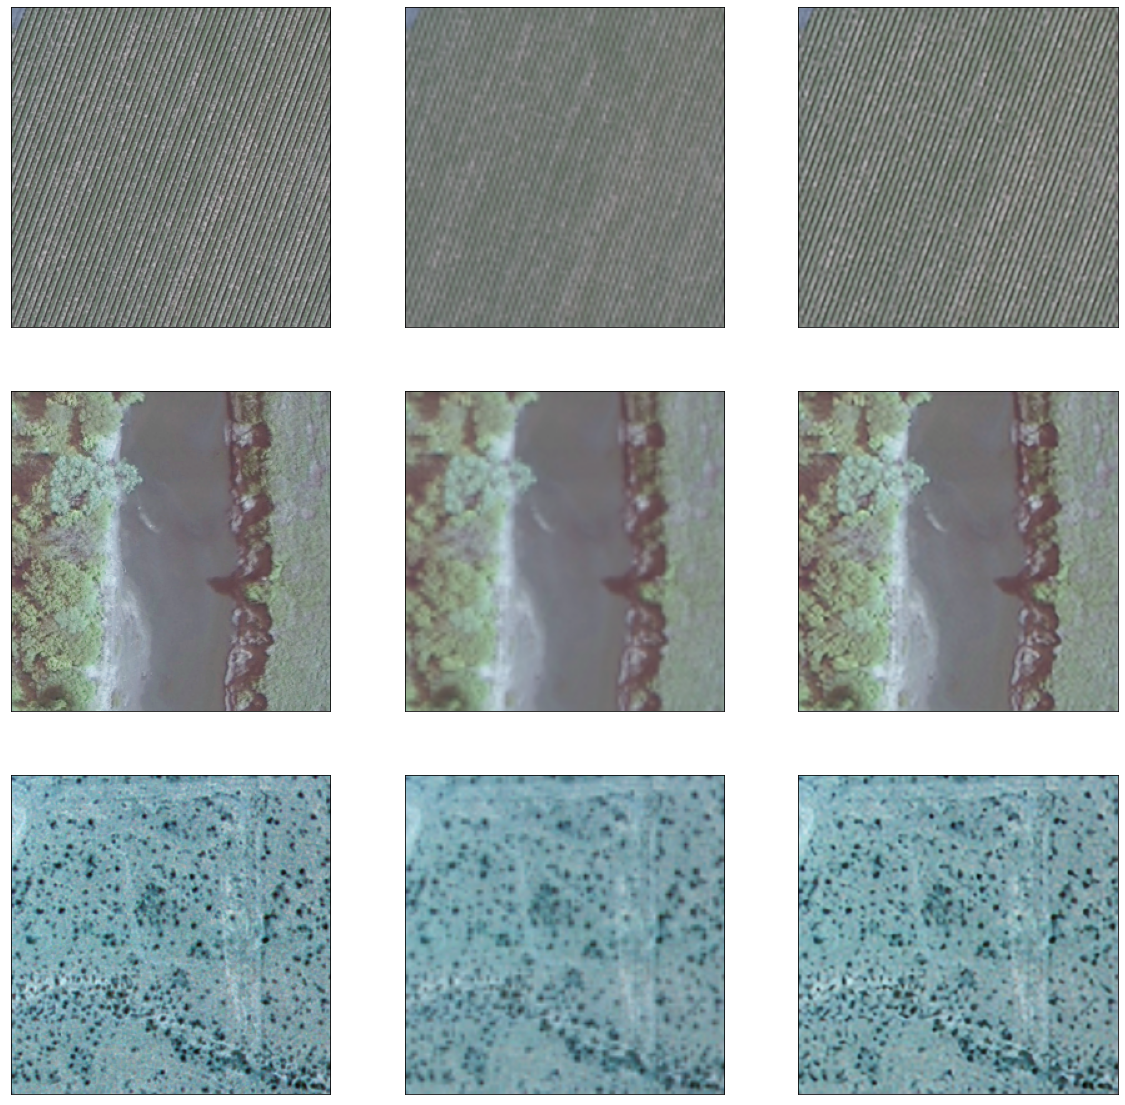

In [ ]:
from random import randint
av = len(x_test_images)
n = 3
fig, axs = plt.subplots(n, 3, figsize=(20, 20))
if n == 1 :
  example = randint(0,av)
  axs[0].imshow(y_test_images[example])
  axs[0].get_xaxis().set_visible(False)
  axs[0].get_yaxis().set_visible(False)

  axs[1].imshow(x_test_images[example])
  axs[1].get_xaxis().set_visible(False)
  axs[1].get_yaxis().set_visible(False)

  axs[2].imshow(predictions[example])
  axs[2].get_xaxis().set_visible(False)
  axs[2].get_yaxis().set_visible(False)
else :
  for i in range(n):
    example = randint(0,av)
    axs[i][0].imshow(y_test_images[example])
    axs[i][0].get_xaxis().set_visible(False)
    axs[i][0].get_yaxis().set_visible(False)

    axs[i][1].imshow(x_test_images[example])
    axs[i][1].get_xaxis().set_visible(False)
    axs[i][1].get_yaxis().set_visible(False)

    axs[i][2].imshow(predictions[example])
    axs[i][2].get_xaxis().set_visible(False)
    axs[i][2].get_yaxis().set_visible(False)
plt.show()

In [ ]:
def Psnr(im1 , im2 , max_value = 1.0):
  im1 = tf.image.convert_image_dtype(im1, tf.float32)
  im2 = tf.image.convert_image_dtype(im2, tf.float32)
  psnr = tf.image.psnr(im1, im2, max_val= max_value)
  return float(psnr)

def mse(target, ref):
    # the MSE between the two images is the sum of the squared difference between the two images
    err = np.sum((target.astype('float') - ref.astype('float')) ** 2)
    err /= float(target.shape[0] * target.shape[1])
    
    return err

def SSIM(im1 , im2 , max_value = 2.0):
  im1 = tf.image.convert_image_dtype(im1, tf.float32)
  im2 = tf.image.convert_image_dtype(im2, tf.float32)
  SSIM = tf.image.ssim(im1, im2, max_val= max_value)
  return float(SSIM)

In [ ]:
ssim = list(map(SSIM,predictions,x_test_images))
mse = list(map(mse, predictions, x_test_images))
Psnr = list(map(Psnr , predictions , x_test_images))

In [ ]:
metrics = pd.DataFrame(list(zip(ssim, Psnr, mse)), 
               columns =['SSIM','PSNR', 'mse' ]) 

In [ ]:
metrics.head()

,SSIM,PSNR,mse
0,0.853609,29.383038,0.003458
1,0.849229,29.740240,0.003185
2,0.681310,23.741129,0.012677
3,0.640643,21.653015,0.020503
4,0.905412,28.457432,0.004279


In [ ]:
metrics.mean(axis = 0)

SSIM     0.943539
PSNR    30.390998
mse      0.004097
dtype: float64

In [ ]:
!mkdir /content/test/

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [ ]:
def preprocess_uploaded_test(filepath):
  image = cv2.imread(filepath ,cv2.IMREAD_COLOR)
  HighRes = resize(image, (256, 256))
  # Add this image to the high res dataset
  # Rescale it 0.5x and 2x so that it is a low res image but still has 256x256 resolution
  LowRes = pixalate_image(HighRes , pixelation_scale = 0.4)
  return HighRes , LowRes

In [ ]:
HR , LR = preprocess_uploaded_test('/content/tenniscourt17.tif')

In [ ]:
test_results = predictions = autoencoder.predict(np.reshape(LR,(1,256,256,3)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


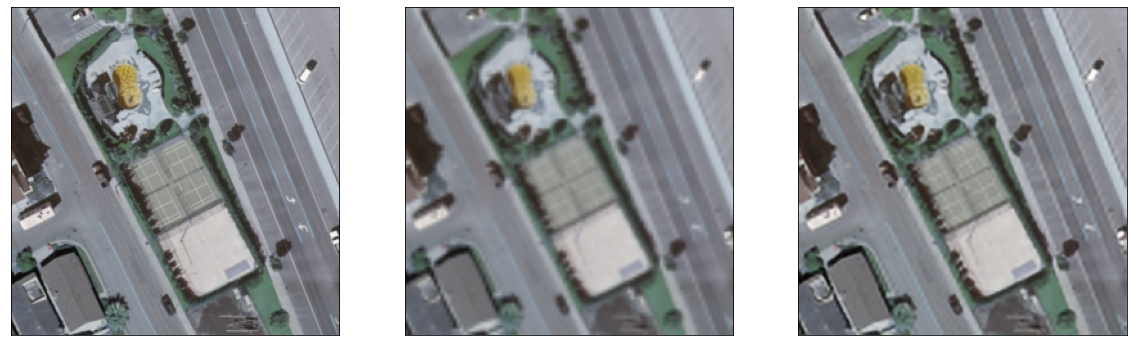

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20, 20))
axs[0].imshow(HR)
axs[0].get_xaxis().set_visible(False)
axs[0].get_yaxis().set_visible(False)

axs[1].imshow(LR)
axs[1].get_xaxis().set_visible(False)
axs[1].get_yaxis().set_visible(False)

axs[2].imshow(test_results[0])
axs[2].get_xaxis().set_visible(False)
axs[2].get_yaxis().set_visible(False)